In [1]:
import pyodbc
import pandas as pd
import numpy as np
from tqdm import tqdm
from sqlalchemy import create_engine
import psutil, os, gc
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to Data Base by Python

In [3]:
conn_str = (
    'mssql+pyodbc://DESKTOP-E490RC6/Instant?'
    'driver=ODBC+Driver+17+for+SQL+Server&'
    'Trusted_Connection=yes'
)

engine = create_engine(conn_str)

In [4]:
query = """
SELECT 
    t.*,
    u.current_age, u.gender, u.yearly_income, u.total_debt, u.credit_score,
    c.card_brand, c.card_type, c.credit_limit, c.has_chip,
    f.fraud_label
FROM transactions t
LEFT JOIN users_data u ON t.client_id = u.id
LEFT JOIN cards_data c ON t.card_id = c.id
LEFT JOIN train_fraud_labels f ON t.id = f.transaction_id
"""

In [5]:
dtype_dict = {
    'current_age': 'int8',
    'yearly_income': 'float32',
    'total_debt': 'float32',
    'credit_score': 'int16',
    'credit_limit': 'float32',
    'gender': 'category',
    'card_brand': 'category',
    'card_type': 'category',
    'has_chip': 'bool',
    'fraud_label': 'category'
}

In [6]:
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

In [7]:
print("Counting total rows...")
total_rows_query = "SELECT COUNT(*) FROM transactions"
with engine.connect() as conn:
    total_rows = pd.read_sql(total_rows_query, conn).iloc[0, 0]
print(f"Total rows to process: {total_rows:,}")

Counting total rows...
Total rows to process: 13,305,915


In [8]:
chunk_size = 5000
chunks = []

print(f"Using chunk size: {chunk_size:,}")

try:
    with tqdm(total=total_rows, desc="Processing chunks", unit="rows") as pbar:
        for chunk in pd.read_sql(query, engine, chunksize=chunk_size):
            pbar.update(len(chunk))
            
            # Optimize data types
            for col in chunk.columns:
                if col in dtype_dict:
                    try:
                        if dtype_dict[col] == 'bool':
                            chunk[col] = chunk[col].astype('bool')
                        else:
                            chunk[col] = chunk[col].astype(dtype_dict[col])
                    except Exception as e:
                        print(f"Warning: Could not convert {col} to {dtype_dict[col]}: {e}")
            
            # Downcast numeric columns
            for col in chunk.select_dtypes(include=['int64']).columns:
                chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
            for col in chunk.select_dtypes(include=['float64']).columns:
                chunk[col] = pd.to_numeric(chunk[col], downcast='float')
            
            chunks.append(chunk)

finally:
    engine.dispose()
    print("Chunk processing complete!")

Using chunk size: 5,000


Processing chunks: 100%|██████████████████████████████████████████████| 13305915/13305915 [12:21<00:00, 17946.60rows/s]

Chunk processing complete!


In [9]:
print("Combining chunks...")
df = pd.concat(chunks, ignore_index=True)

del chunks
gc.collect()

print("Processing complete!")

Combining chunks...
Processing complete!


# Data Exploration

In [11]:
print("=== DATA OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Fraud ratio: {df['fraud_label'].eq('Yes').mean():.6f}" if 'fraud_label' in df.columns else 'No fraud labels')

=== DATA OVERVIEW ===
Shape: (13305915, 22)
Columns: ['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors', 'current_age', 'gender', 'yearly_income', 'total_debt', 'credit_score', 'card_brand', 'card_type', 'credit_limit', 'has_chip', 'fraud_label']
Fraud ratio: 0.001002


In [12]:
print("=== DATA TYPES ===")
print(df.dtypes)

=== DATA TYPES ===
id                   int32
date                object
client_id            int16
card_id              int16
amount              object
use_chip            object
merchant_id         object
merchant_city       object
merchant_state      object
zip                 object
mcc                 object
errors              object
current_age           int8
gender            category
yearly_income      float32
total_debt         float32
credit_score         int16
card_brand        category
card_type         category
credit_limit       float32
has_chip              bool
fraud_label         object
dtype: object


In [13]:
print("=== MISSING VALUES ===")
print(df.isnull().sum())

=== MISSING VALUES ===
id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
current_age              0
gender                   0
yearly_income            0
total_debt               0
credit_score             0
card_brand               0
card_type                0
credit_limit             0
has_chip                 0
fraud_label        4390952
dtype: int64


In [14]:
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,current_age,gender,yearly_income,total_debt,credit_score,card_brand,card_type,credit_limit,has_chip,fraud_label
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,30,Female,48277.0,110153.0,740,Mastercard,Debit (Prepaid),55.0,True,No
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,48,Male,36853.0,112139.0,834,Mastercard,Credit,9100.0,True,No
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,49,Male,34449.0,36540.0,686,Mastercard,Debit,14802.0,True,No
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,52,Female,53350.0,128676.0,685,Mastercard,Debit,37634.0,False,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,51,Male,68362.0,96182.0,711,Visa,Debit,19113.0,True,No


# Data Cleaning

## Fix Data Type Issues

In [17]:
df['amount'] = df['amount'].str.replace('$', '', regex=False)
df['amount'].head()

0    -77.00
1     14.57
2     80.00
3    200.00
4     46.41
Name: amount, dtype: object

In [18]:
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

Interpreting positive amounts as credits and negative amounts as debits reflects conventional treatment of financial transactions

In [20]:
# Create separate columns for credits and debits
df['credit_amount'] = df['amount'].where(df['amount'] >= 0, 0)      # Positive amounts only
df['debit_amount'] = df['amount'].where(df['amount'] < 0, 0).abs()  # Absolute negative amounts

In [21]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [22]:
df.use_chip.value_counts()

use_chip
Swipe Transaction     6967185
Chip Transaction      4780818
Online Transaction    1557912
Name: count, dtype: int64

In [23]:
df['use_chip'] = df['use_chip'].astype('category')

In [24]:
print("Data types after optimization:")
print(df.dtypes)

Data types after optimization:
id                         int32
date              datetime64[ns]
client_id                  int16
card_id                    int16
amount                   float64
use_chip                category
merchant_id               object
merchant_city             object
merchant_state            object
zip                       object
mcc                       object
errors                    object
current_age                 int8
gender                  category
yearly_income            float32
total_debt               float32
credit_score               int16
card_brand              category
card_type               category
credit_limit             float32
has_chip                    bool
fraud_label               object
credit_amount            float64
debit_amount             float64
dtype: object


## Handle Missing Values

In [26]:
print(df.isnull().sum())

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
current_age              0
gender                   0
yearly_income            0
total_debt               0
credit_score             0
card_brand               0
card_type                0
credit_limit             0
has_chip                 0
fraud_label        4390952
credit_amount            0
debit_amount             0
dtype: int64


In [27]:
# For high-missing categorical columns, use 'Unknown' category
df['merchant_state'] = df['merchant_state'].fillna('Unknown')
df['zip'] = df['zip'].fillna('Unknown')

In [28]:
df['errors'].value_counts()

errors
Insufficient Balance                                     130902
Bad PIN                                                   32119
Technical Glitch                                          26271
Bad Card Number                                            7767
Bad Expiration                                             6161
Bad CVV                                                    6106
Bad Zipcode                                                1126
"Bad PIN,Insufficient Balance"                              293
"Insufficient Balance,Technical Glitch"                     243
"Bad Card Number,Insufficient Balance"                       71
"Bad PIN,Technical Glitch"                                   70
"Bad CVV,Insufficient Balance"                               57
"Bad Expiration,Insufficient Balance"                        47
"Bad Card Number,Bad CVV"                                    38
"Bad Card Number,Bad Expiration"                             33
"Bad Expiration,Bad CVV"         

In [29]:
# For errors - 98.4% missing, probably means no errors
df['errors'] = df['errors'].fillna('No Error')

In [30]:
# Check if missing values follow any pattern
missing_fraud = df[df['fraud_label'].isna()]
non_missing_fraud = df[~df['fraud_label'].isna()]

print(f"Total rows: {len(df)}")
print(f"Missing fraud labels: {len(missing_fraud)}")
print(f"Non-missing fraud labels: {len(non_missing_fraud)}")

Total rows: 13305915
Missing fraud labels: 4390952
Non-missing fraud labels: 8914963


In [31]:
# Compare statistics between missing and non-missing groups
print("\nComparison of means:")
print(pd.DataFrame({
    'Missing': missing_fraud[['amount', 'credit_score']].mean(),
    'Non-Missing': non_missing_fraud[['amount', 'credit_score']].mean()
}))


Comparison of means:
                 Missing  Non-Missing
amount         43.030150    42.949387
credit_score  713.881251   713.926151


Key Findings:

33% of data is missing fraud labels (4.39M out of 13.3M rows)

No significant difference in means between missing and non-missing groups

    amount: 43.03 vs 42.95 (very similar)

    credit_score: 713.88 vs 713.93 (almost identical)

This suggests the missingness is likely random rather than systematic.

In [33]:
df['fraud_label'] = df['fraud_label'].fillna('unlabeled')

In [34]:
print("Missing values after filling:")
print(df.isnull().sum())

Missing values after filling:
id                0
date              0
client_id         0
card_id           0
amount            0
use_chip          0
merchant_id       0
merchant_city     0
merchant_state    0
zip               0
mcc               0
errors            0
current_age       0
gender            0
yearly_income     0
total_debt        0
credit_score      0
card_brand        0
card_type         0
credit_limit      0
has_chip          0
fraud_label       0
credit_amount     0
debit_amount      0
dtype: int64


In [35]:
df.duplicated().sum()

0

In [36]:
df = df[(df['current_age'] >= 18) & (df['current_age'] <= 100)]

In [37]:
df['age_group'] = pd.cut(df['current_age'], 
                         bins=[0, 25, 35, 45, 55, 65, 100],
                         labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

# Save cleaned CSV file

In [45]:
chunk_size = 50000

print(f"Saving {len(df):,} rows to transactions_cleaned.csv...")

with tqdm(total=len(df), desc="Saving CSV", unit="rows", 
          bar_format='{l_bar}{bar:50}{r_bar}{bar:-50b}') as pbar:
    df.to_csv("transactions_cleaned.csv", index=False, chunksize=chunk_size)
    pbar.update(len(df)) 

print("Save completed successfully!")

Saving 13,290,503 rows to transactions_cleaned.csv...


Saving CSV: 100%|██████████████████████████████████████████████████| 13290503/13290503 [05:30<00:00, 40252.27rows/s]   

Save completed successfully!


# Analysis

In [47]:
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,total_debt,credit_score,card_brand,card_type,credit_limit,has_chip,fraud_label,credit_amount,debit_amount,age_group
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,110153.0,740,Mastercard,Debit (Prepaid),55.0,True,No,0.00,77.0,26-35
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,112139.0,834,Mastercard,Credit,9100.0,True,No,14.57,0.0,46-55
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,36540.0,686,Mastercard,Debit,14802.0,True,No,80.00,0.0,46-55
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,128676.0,685,Mastercard,Debit,37634.0,False,unlabeled,200.00,0.0,46-55
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,96182.0,711,Visa,Debit,19113.0,True,No,46.41,0.0,46-55


## Basic statistics

In [50]:
total_transactions = len(df)
total_clients = df['client_id'].nunique()
total_cards = df['card_id'].nunique()

In [51]:
print(f"Total Transactions: {total_transactions:,}")
print(f"Total Clients: {total_clients:,}")
print(f"Total Cards: {total_cards:,}")

Total Transactions: 13,290,503
Total Clients: 1,218
Total Cards: 4,068


## Average values

In [60]:
avg_transaction = df['amount'].mean()
print(f"Average Transaction Amount: ${avg_transaction:.2f}")

Average Transaction Amount: $43.00


In [62]:
avg_credit_score = df['credit_score'].mean()
print(f"Average Credit Score: {avg_credit_score:.1f}")

Average Credit Score: 713.9


In [63]:
avg_income = df['yearly_income'].mean()
print(f"Average Yearly Income: ${avg_income:,.2f}")

Average Yearly Income: $46,720.02


## Time period

In [65]:
dates = pd.to_datetime(df['date'])
date_range = f"{dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}"
print(f"Date Range: {date_range}")

Date Range: 2010-01-01 to 2019-10-31


## What is the age distribution of users by gender?

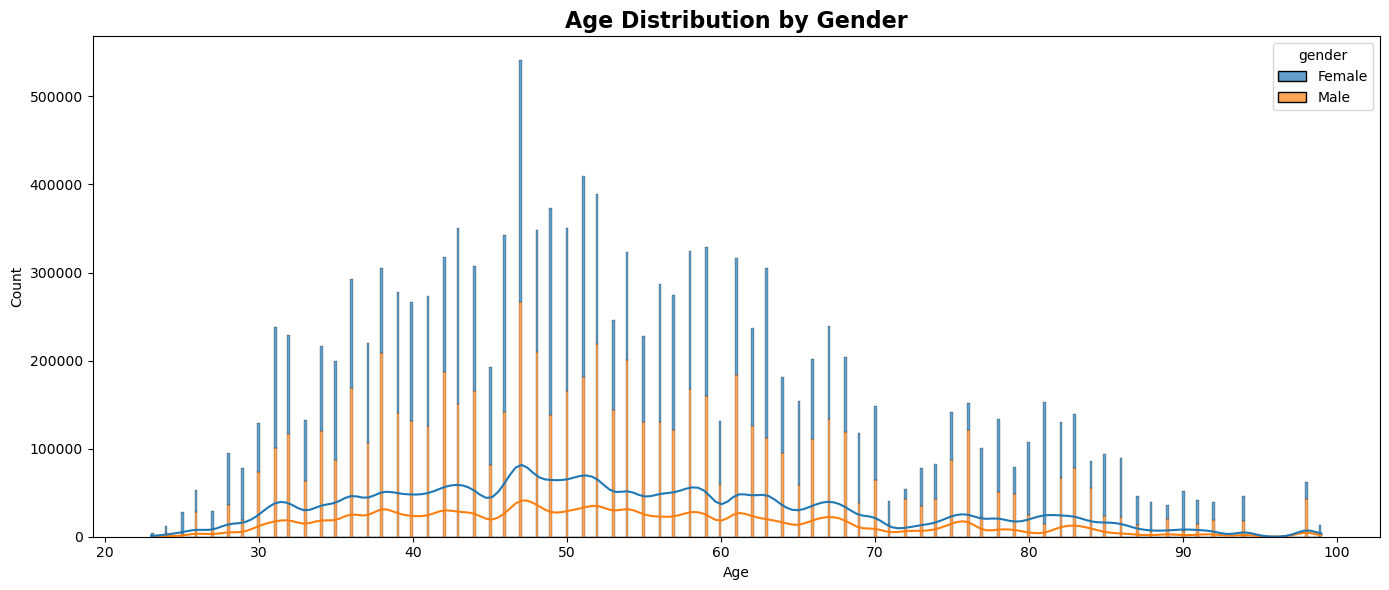

In [77]:
plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='current_age', hue='gender', multiple='stack', kde=True, alpha=0.7)
plt.title('Age Distribution by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Age distribution shows balanced gender representation across all age groups from 0-100 years, with typical demographic patterns showing higher density in working-age populations.

## How does credit score distribution vary by gender?

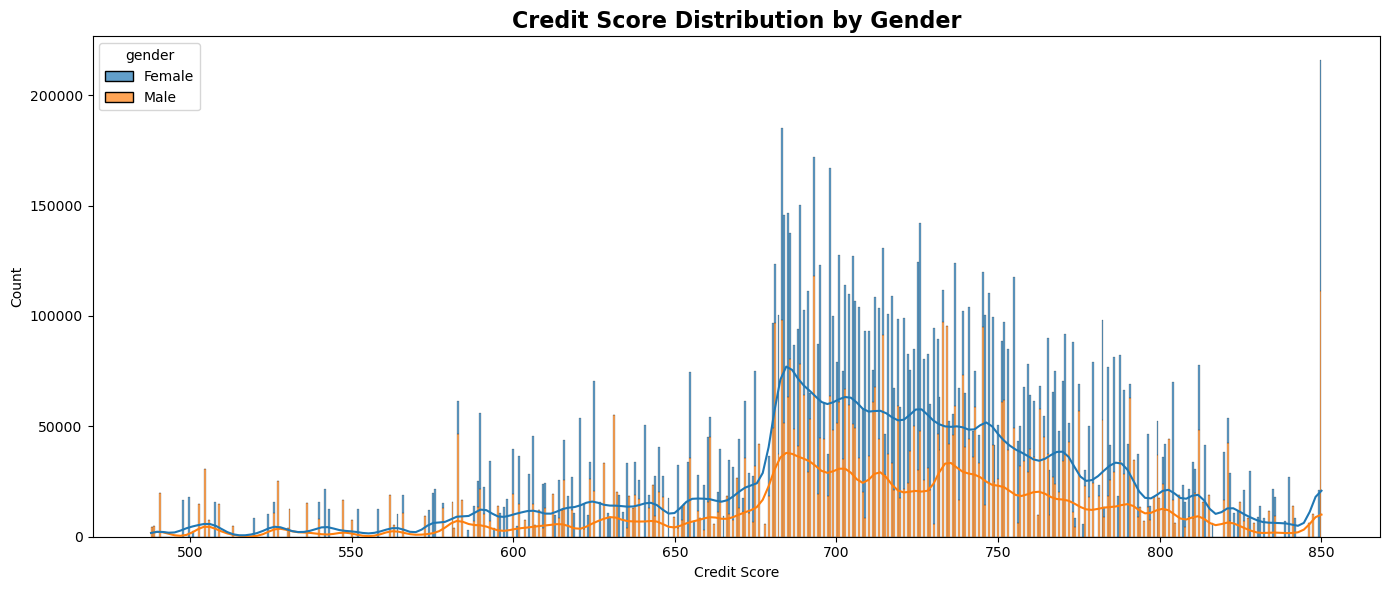

In [80]:
plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='credit_score', hue='gender', multiple='stack', kde=True, alpha=0.7)
plt.title('Credit Score Distribution by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Credit scores show similar distribution patterns across genders, with peak concentrations in the 650-750 range for both males and females.

## How is debt distributed across genders?

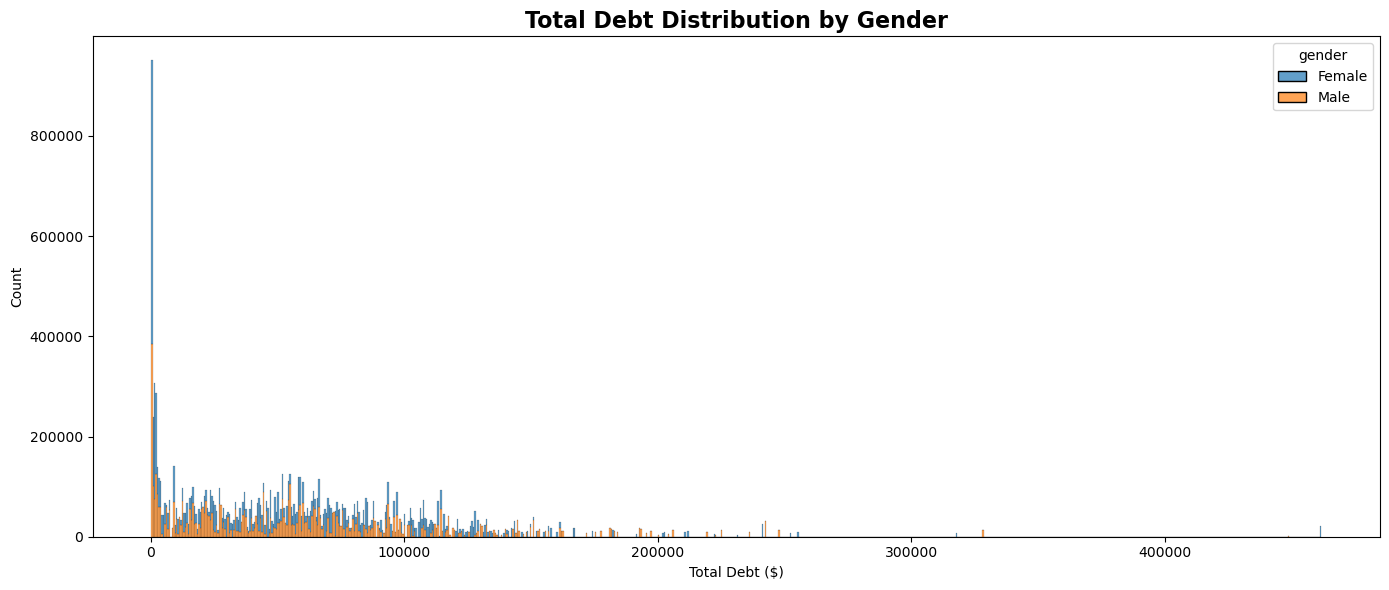

In [86]:
plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='total_debt', hue='gender', multiple='stack', alpha=0.7)
plt.title('Total Debt Distribution by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Total Debt ($)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Debt distribution shows similar patterns across genders, with most individuals concentrated in lower debt ranges below $250,000.

## What is the distribution of card types by brand?

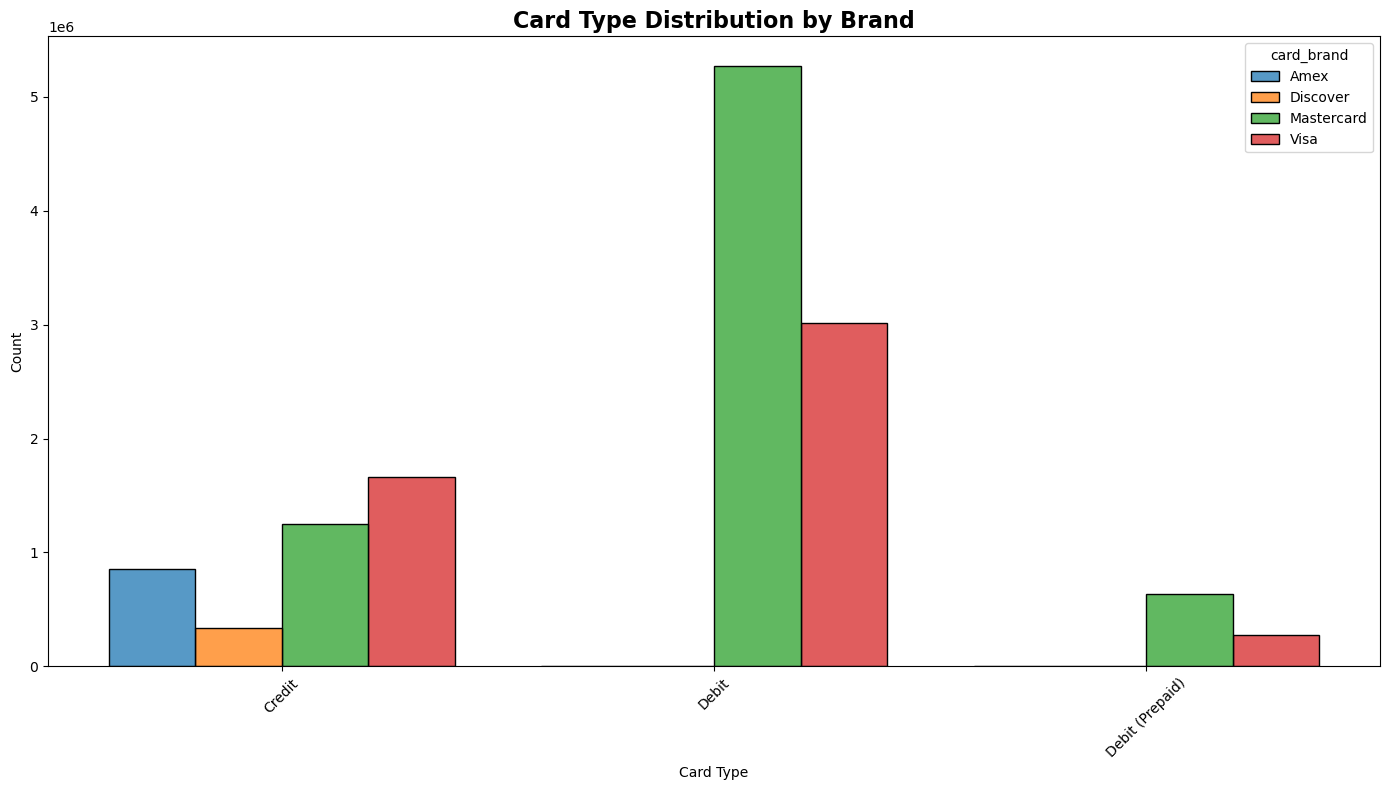

In [93]:
plt.figure(figsize=(14, 8))
sns.histplot(data=df, x='card_type', hue='card_brand', multiple='dodge', shrink=0.8)
plt.title('Card Type Distribution by Brand', fontsize=16, fontweight='bold')
plt.xlabel('Card Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mastercard dominates debit cards, while Visa has a strong presence in both credit and debit types. Amex and Discover are only used for credit cards.

## What is the distribution of transaction amounts?

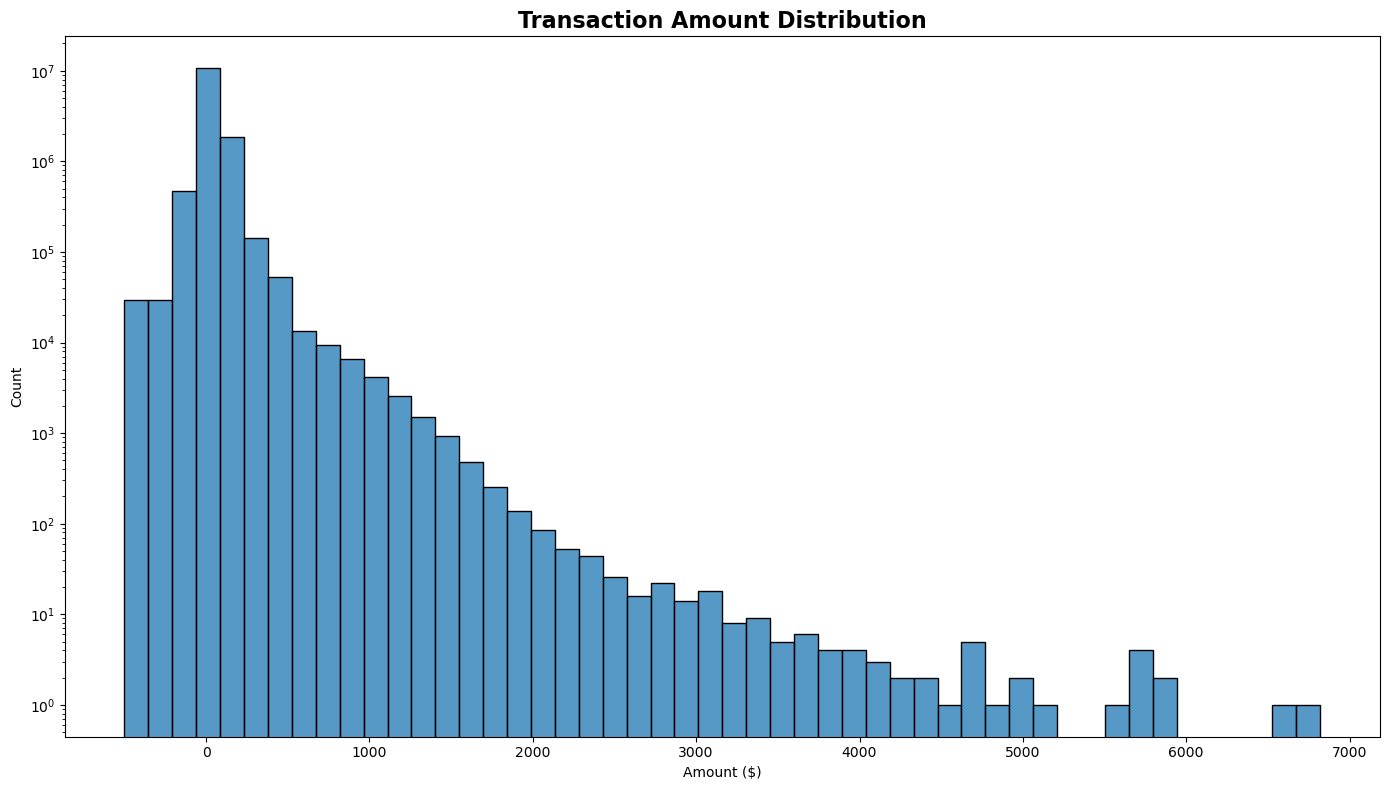

In [100]:
plt.figure(figsize=(14, 8))
sns.histplot(data=df, x='amount', bins=50)
plt.title('Transaction Amount Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Amount ($)')
plt.ylabel('Count')
plt.yscale('log')
plt.tight_layout()
plt.show()

Transaction amounts show a highly right-skewed distribution with most transactions under $1,000.

## How have transactions evolved over time?

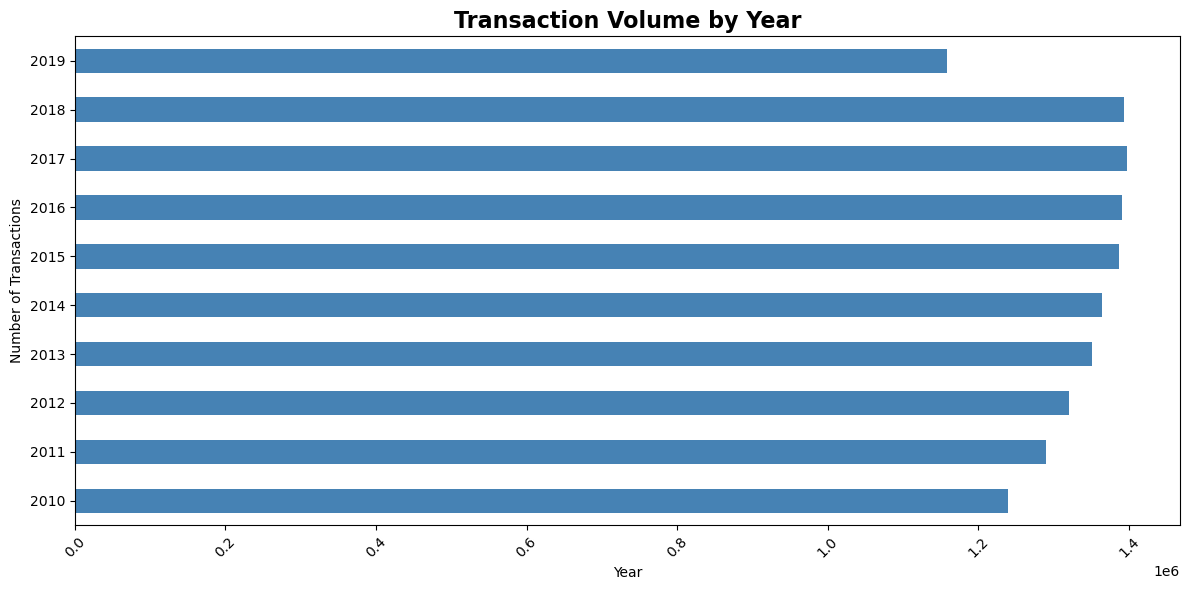

In [103]:
df['year'] = pd.to_datetime(df['date']).dt.year
yearly_transactions = df['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
yearly_transactions.plot(kind='barh', color='steelblue')
plt.title('Transaction Volume by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Steady growth from 2010-2018 followed by unexpected 2019 decline requiring investigation.

## Statistical distribution of transaction amounts

In [106]:
print("\nTransaction Amount Statistics:")
print(df['amount'].describe().round(2))
print("\nPercentile Values:")
print(df['amount'].quantile([0.0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]).round(2))


Transaction Amount Statistics:
count    13290503.00
mean           43.00
std            81.67
min          -500.00
25%             8.93
50%            28.99
75%            63.71
max          6820.20
Name: amount, dtype: float64

Percentile Values:
0.00    -500.00
0.25       8.93
0.50      28.99
0.75      63.71
0.90     104.97
0.95     146.00
0.99     316.00
1.00    6820.20
Name: amount, dtype: float64


## What percentage of transactions are fraudulent?

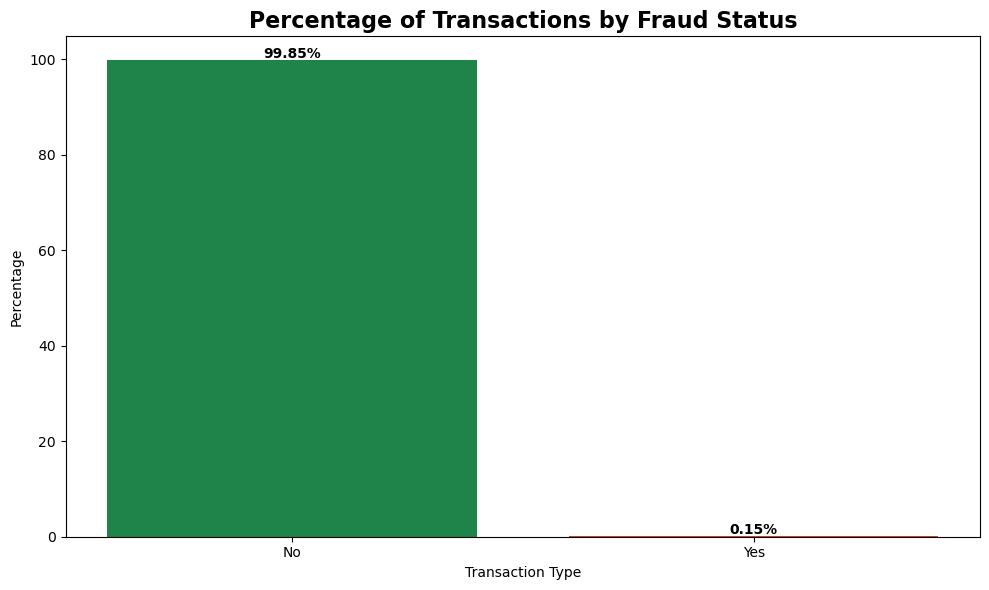


Fraud rate: 0.15%


In [109]:
fraud_filtered = df[df['fraud_label'].isin(['Yes', 'No'])]
fraud_percentage = fraud_filtered['fraud_label'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
colors = ['#1e8449', '#cb4335']  # Green for No, Red for Yes
bars = plt.bar(fraud_percentage.index, fraud_percentage.values, color=colors)
plt.title('Percentage of Transactions by Fraud Status', fontsize=16, fontweight='bold')
plt.xlabel('Transaction Type')
plt.ylabel('Percentage')

for i, v in enumerate(fraud_percentage.values):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nFraud rate: {fraud_percentage.get('Yes', 0):.2f}%")